In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tiepy.speckle.io import load_tiff_as_npy, print_h5_keys, save_dict_to_h5, load_key_from_virtual_h5, create_virtual_h5

from tiepy.speckle.subpixel import process_single_image, process_subset_images, calculate_normalized_correlation
from tiepy.speckle.utils import get_subsets, reshape_to_2d, calc_subsets_size

from PIL import Image
from tqdm import tqdm

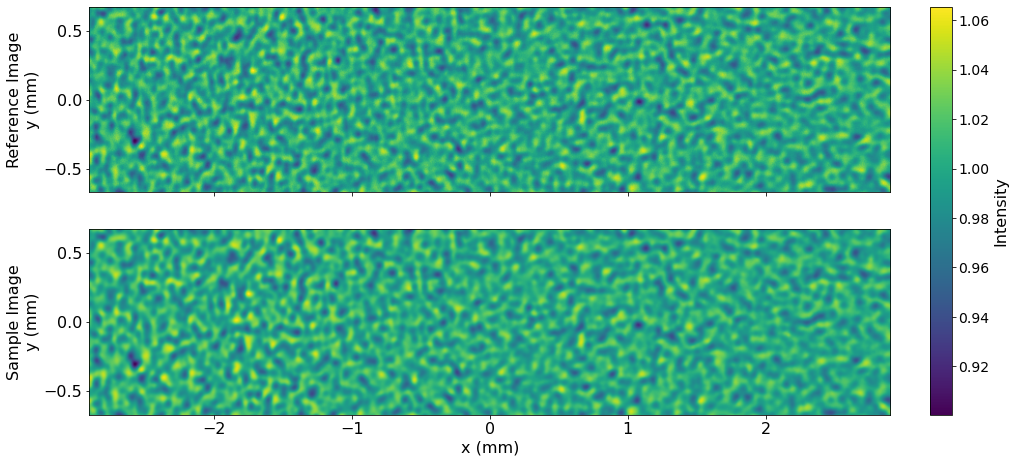

In [2]:

# Load the Data and scale to image mean
IR = load_tiff_as_npy("./data/speckle00.tif")
IS = load_tiff_as_npy("./data/speckle01.tif")

IR/= np.mean(IR)
IS/= np.mean(IS)
     
# Assuming IR and IS are the two images
z = 3.5  # speckle to detector distance
dx = dy = 7e-06  # pixel size

# Set array dimensions
ny, nx = IR.shape

x_axis = np.linspace(-dx * (nx // 2), dx * (nx // 2), nx) * 1e3  # in microns
y_axis = np.linspace(-dy * (ny // 2), dy * (ny // 2), nx) * 1e3  # in microns

# Plot Reference and Sample Speckle
fig, axes = plt.subplots(2, 1, figsize=(15, 7.5), sharex=True)
[ax1, ax2] = axes

# Plot IR (Reference Image)
im1 = ax1.imshow(IR, extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()])
ax1.set_ylabel("Reference Image\ny (mm)", fontsize=16)

# Plot IS (Sample Image)
im2 = ax2.imshow(IS, extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()])
ax2.set_ylabel("Sample Image\ny (mm)", fontsize=16)
ax2.set_xlabel("x (mm)", fontsize=16)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=16)

# Add a vertical colorbar to the right of the subplots
cax = fig.add_axes([0.92, 0.125, 0.02, 0.755])  # [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Intensity', fontsize=16)

plt.show()

In [3]:
window_size = 50
step_size = 25

calc_subsets_size(IS,
                       window_size = window_size,
                       step_size = step_size,
                       padding = window_size//2)

Number of Subsets: 120


In [4]:
results = process_single_image(IR,
                            IS,
                            window_size = window_size,
                            step_size = step_size,
                            padding = window_size//2,
                            plot = False)

save_dict_to_h5(results, "./h5/test.h5")

create_virtual_h5("./h5/", "./virtual_dataset.h5")

120it [00:50,  2.38it/s]


Virtual dataset created in ./virtual_dataset.h5


In [39]:
results = load_key_from_virtual_h5("./virtual_dataset.h5", "test")

# Assuming IR and IS are the two images
z = 3.5  # speckle to detector distance
dx = dy = 7e-06 # pixel size # in mm

cx = results['coords_x'] * dx
cy = results['coords_y'] * dy

sx = results['shifts_x'] * dx
sy = results['shifts_y'] * dy

ssx = results['subpixel_shifts_x'] * dx
ssy = results['subpixel_shifts_y'] * dy

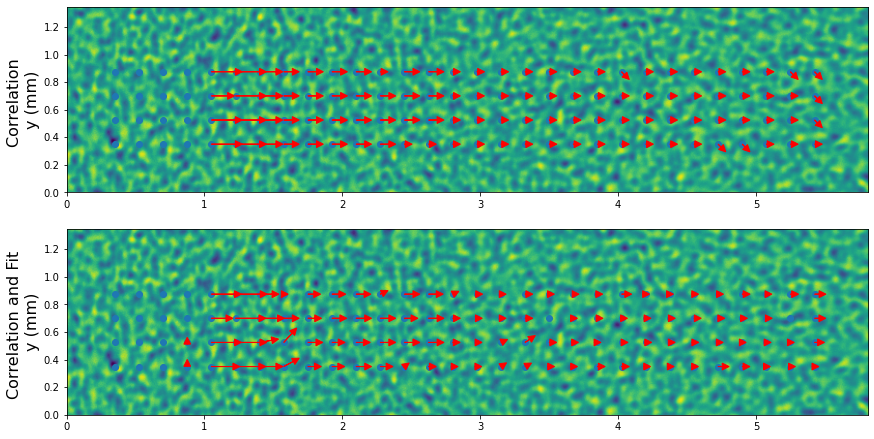

In [77]:

# Plot Reference and Sample Speckle
fig, axes = plt.subplots(2, 1, figsize=(15, 7.5), sharex=False)
[ax1, ax2] = axes

# Set array dimensions
ny, nx = IR.shape

scale = 1e3 #plot in mm

x_axis = np.linspace(0, dx * (nx) , nx) * scale
y_axis = np.linspace(0, dy * (ny) , ny) * scale

# Plot IR (Reference Image)
im1 = ax1.imshow(IR, extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()])
im2 = ax2.imshow(IR, extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()])

ax1.set_ylabel("Correlation \ny (mm)", fontsize=16)
ax2.set_ylabel("Correlation and Fit \ny (mm)", fontsize=16)

ax1.scatter(cx*scale, cy*scale)
ax2.scatter(cx*scale, cy*scale)

max_arrow_len = 8
head_len = 0.05
head_width = 0.05

threshold = 0.33
# Threshold 
ssx[np.where(abs(ssx)/dx < threshold)] = 0
ssy[np.where(abs(ssy)/dy < threshold)] = 0


for i in range(cx.shape[0]):
    for j in range(cy.shape[1]):

        
        # Plot Shifts
        ax1.arrow(cx[i,j]*scale, cy[i,j] *scale,
                  sx[i,j]*scale * max_arrow_len, sy[i,j]*scale*max_arrow_len,
               head_width=head_width, head_length=head_len, fc='red', ec='red', 
               length_includes_head =  True)

        # Plot Sub-Pixel Shifts
        ax2.arrow(cx[i,j]*scale, cy[i,j]*scale ,
                  ssx[i,j]*scale * max_arrow_len, ssy[i,j]*scale*max_arrow_len,
               head_width=head_width, head_length=head_len, fc='red', ec='red', 
               length_includes_head =  True)
 